In [1]:
import sys

import numpy as np
import matplotlib.pyplot as plt

import copy

sys.path.insert(1, '../metadl/baselines/sentive_ai')
from sentive.sentive_vision_network import sentive_vision_network

from sentive.sentive_brain import sentive_brain

root_ep = 'episode_'
suf_eptest = '_1.csv'
root_test= 'test_'

episode = np.zeros([1,5,28,28,2])
test = np.zeros([5, 28,28,2])
for i in range(5):
    episode[0][i][:,:,0] = np.loadtxt(root_ep+str(i)+suf_eptest)
    episode[0][i][:,:,1] = np.loadtxt(root_ep+str(i)+suf_eptest)

    test[i][:,:,0] = np.loadtxt(root_test+str(i)+suf_eptest)
    test[i][:,:,1] = np.loadtxt(root_test+str(i)+suf_eptest)


nombre de neurones taille 1: 56


______________________________________________________________________________________
nrn2 id 57
new_x 9
new_y 7
central_pixel_id 1
nrn_pxl_map[new_y][x] 1.0
tmp_sub_pxl_map :
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 2. 3.]]
tmp_list_sub_pxl [0, 2, 3]
nrn_pxl_id 2
nrn_pxl id & weight : 2 0.9633017778396606
nrn_pxl_id 3
nrn_pxl id & weight : 3 0.9887948036193848
x_composant [0.0, 0.9887948036193848]
y_composant [0.9633017778396606, 0.9887948036193848]
vecteur orientation sans shift: 0.506529652790199 1.0
PROCHAIN NEURONE: [new_x: 10 , new_y: 8 ]
PROCHAIN NEURONE SANS CHANGEMENT: [new_x: 10 , new_y: 8 ]
mtrx_weights_pxl:
 [[0.         0.         0.        ]
 [0.         0.94592118 0.        ]
 [0.         0.96330178 0.9887948 ]]
neurone a supprimer dans la matrice : x : 2 y: 2
mtrx_weights_pxl:
 [[0.         0.         0.        ]
 [0.         0.94592118 0.        ]
 [0.         0.96330178 0.        ]]
barycentre [1.         1.50455175]
###########################

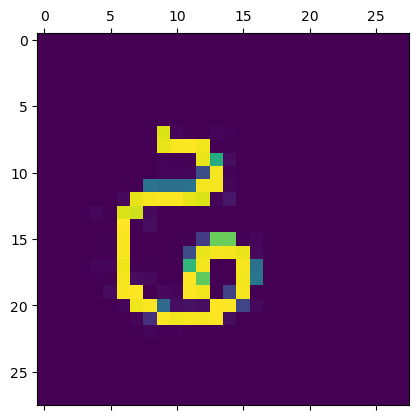

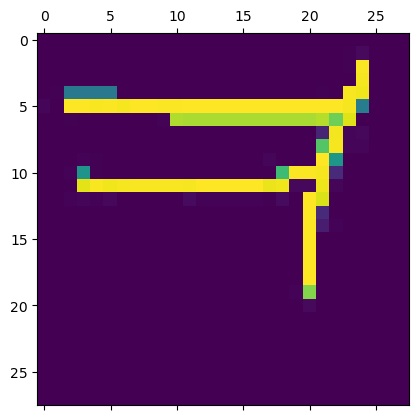

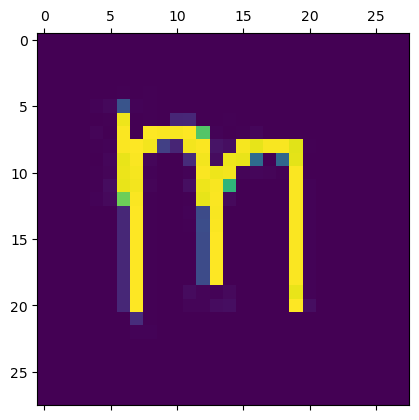

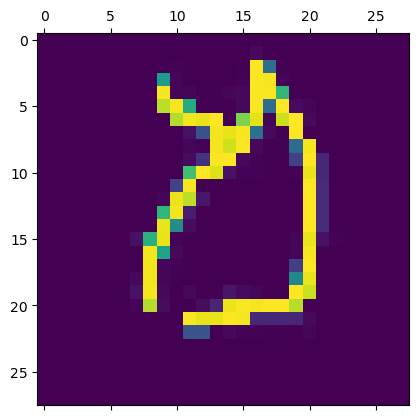

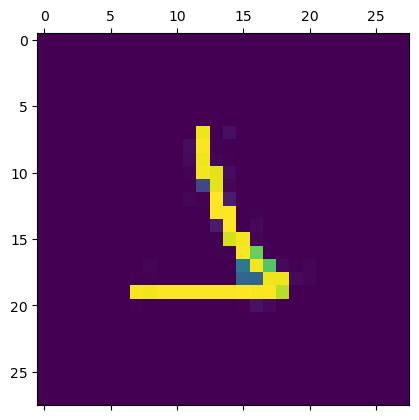

In [2]:
sbrain = sentive_brain(episode,5)

In [3]:
def compare_matrices(desired_mtrx, mtrx):
    if desired_mtrx.shape != mtrx.shape:
        raise ValueError("Les deux matrices n'ont pas la même forme")
    
    corr_matrix = np.corrcoef(desired_mtrx.flatten(), mtrx.flatten())
    similarity_score = np.abs(corr_matrix[0, 1]).mean()
    print(corr_matrix[0, 1])
    
    return similarity_score

In [4]:
def find_line(x1, y1, x2, y2):
    if x1 == x2:
        return (None, x1)
    elif y1 == y2:
        return (0, y1)
    else:
        a = (y2 - y1) / (x2 - x1)
        b = y1 - a * x1
        return (a, b)


def dot_on_line(x, y, a, b):
    return y == a * x + b

In [5]:
# to be removed                                                    
char_id = 0
self = sbrain.nnet[char_id]        
# to be removed 


In [6]:
sbrain.nnet[char_id].nrn_tls.get_neuron_from_id(103)

{'_id': 103,
 'schema_version': 2,
 'type': 'sentive_vision_curve',
 'layer_id': 2,
 'DbConnectivity': {'pre_synaptique': [102],
  'post_synaptique': [],
  'lateral_connexion': [],
  'anti_lateral': [98],
  'weights': {}},
 'meta': {'threshold': 0.7,
  'pending_nb_iteration': 1,
  'averaged_prediction': 0.0,
  'last_vector': {'x': 0.0, 'y': 0.0},
  'curve': {'starting_point': {'x': 12.0, 'y': 18.56499257924946},
   'basis_vector': {'x': -0.7576917352294457, 'y': 0.49789871554767895},
   'nb_iteration': 1,
   'angle': 0.0,
   'acceleration': 0.0,
   'malm_angle': 0.0,
   'malm_acceleration': 0.0},
  'pixels_matrix': []}}

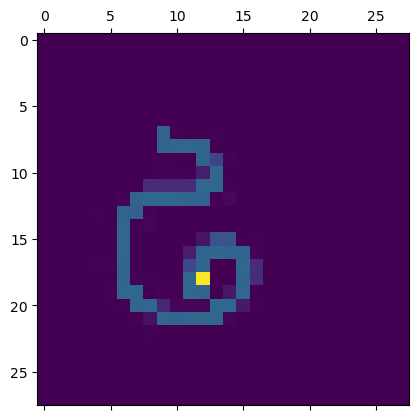

In [7]:
sbrain.nnet[char_id].show_receptive_field_id(104)

In [8]:
x = [0]
y = []
h = []
cumsum_x = 0
last_angle = 0
for nrn in sbrain.nnet[char_id].nrn_tls.lst_nrns:
    if nrn.neuron["type"] == "sentive_vision_curve":
        cumsum_x += nrn.neuron["meta"]["curve"]["nb_iteration"]
        x.append(cumsum_x)
        x.append(cumsum_x)
        print(nrn.neuron["_id"], ":", nrn.neuron["meta"]["curve"]["starting_point"], " *", nrn.neuron["meta"]["curve"]["nb_iteration"],"* ",cumsum_x,",",  nrn.neuron["meta"]["curve"]["angle"])
        last_angle = nrn.neuron["meta"]["curve"]["angle"]
        y.append(last_angle)
        y.append(last_angle)
        tmp_h = np.ones( nrn.neuron["meta"]["curve"]["nb_iteration"]) * last_angle
        h.extend(tmp_h)
y.append(last_angle)        
print("_______________________________________________________")
for nrn in sbrain.nnet[char_id].nrn_tls.lst_nrns:
    if nrn.neuron["type"] == "sentive_vision_line":
        print(nrn.neuron["_id"],  ":", nrn.neuron["meta"]["line"]["starting_point"] , " *", nrn.neuron["meta"]["line"]["nb_iteration"],"* ", )

58 : {'x': 9.0, 'y': 7.5045517458062925}  * 3 *  3 , -0.4665412018098977
63 : {'x': 12.0, 'y': 8.0}  * 6 *  9 , 0.5156498132011182
71 : {'x': 8.493806894404415, 'y': 11.0}  * 3 *  12 , 0.1199502400272397
76 : {'x': 7.0, 'y': 13.0}  * 4 *  16 , -0.513241733826589
81 : {'x': 6.0, 'y': 17.0}  * 5 *  21 , -0.4373020102223792
87 : {'x': 9.0, 'y': 20.0}  * 10 *  31 , -0.39491418598381556
98 : {'x': 13.500313705155467, 'y': 15.0}  * 3 *  34 , 0.10798974815893718
103 : {'x': 12.0, 'y': 18.56499257924946}  * 1 *  35 , 0.0
_______________________________________________________
59 : {'x': 9.0, 'y': 7.5045517458062925}  * 9 * 
64 : {'x': 12.0, 'y': 8.0}  * 3 * 
72 : {'x': 8.493806894404415, 'y': 11.0}  * 9 * 
99 : {'x': 13.500313705155467, 'y': 15.0}  * 3 * 
104 : {'x': 12.0, 'y': 18.56499257924946}  * 1 * 


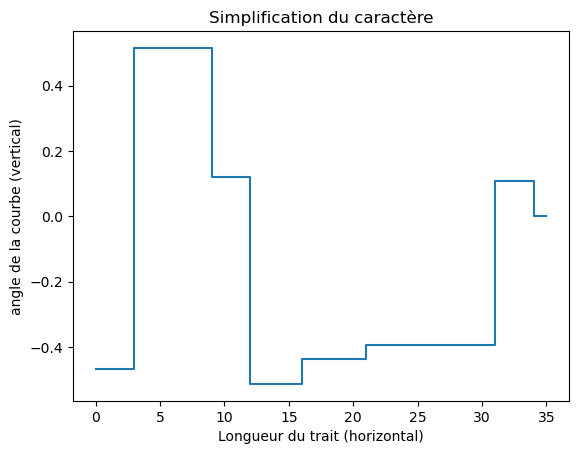

In [9]:
# tracer un graphique en escalier avec les points fournis
plt.plot(x, y, drawstyle='steps-post')

# ajouter des titres et des étiquettes d'axes
plt.title('Simplification du caractère')
plt.xlabel('Longueur du trait (horizontal)')
plt.ylabel('angle de la courbe (vertical)')

# afficher le graphique
plt.show()


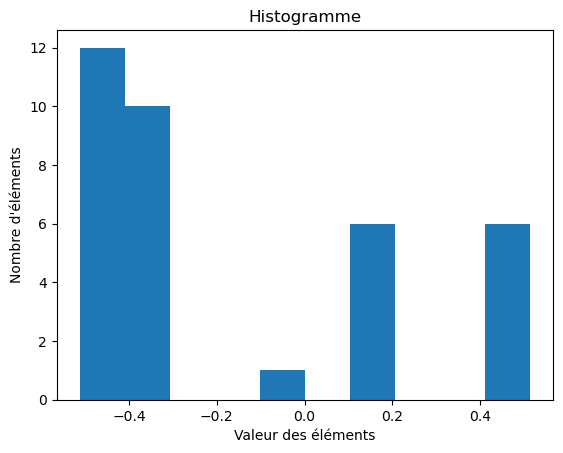

In [10]:
# tracer un histogramme avec les données fournies
plt.hist(h, bins=10)

# ajouter des titres et des étiquettes d'axes
plt.title('Histogramme')
plt.xlabel('Valeur des éléments')
plt.ylabel('Nombre d\'éléments')

# afficher le graphique
plt.show()


**nrn_drawer** : position de départ x 6 y 15
**nrn_drawer** : position intermédiaire x 6 y 17
**nrn_drawer** : position intermédiaire x 6 y 18
**nrn_drawer** : position intermédiaire x 7 y 19
**nrn_drawer** : position intermédiaire x 7 y 20
**nrn_drawer** : position intermédiaire x 8 y 20
**nrn_drawer** : position intermédiaire x 9 y 21
**nrn_drawer** : position intermédiaire x 10 y 21
**nrn_drawer** : position intermédiaire x 11 y 22
**nrn_drawer** : angle final: -0.15138697720744618
**nrn_drawer** : position finale x 11 y 22
**nrn_drawer** : dernier vector {'x': 0.9360022846185548, 'y': 0.351993924931733}


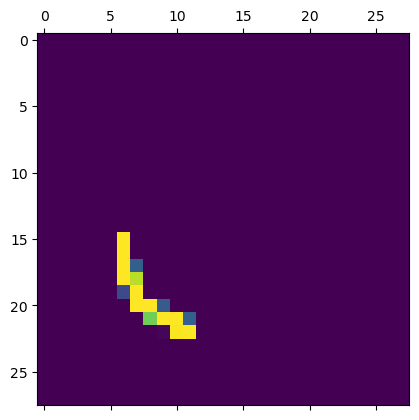

In [11]:
mtrx = np.zeros([28,28])
vector_1= {
    "x" : 0, 
    "y" : 1
}
angle =  -0.15138697720744618
acc =  0
length = 9
start= {
    "x" : 6,
    "y" : 15
}

mtrx, angle, start, vector_1, _ = sbrain.nnet[0].nrn_tls.nrn_drawer(mtrx, vector_1, angle, length, start,acc)
plt.matshow(mtrx)

In [12]:
vector_1 = {
    "x": 0.4223896117376803,
    "y": -1.1496568147231787
}
vector_2 = {
    "x": -1.0062661425036992,
    "y": -1.0
}
self.nrn_tls.calc_angle(vector_1, vector_2)

-1.1406168716388418

In [13]:
vector={
    "x": 0.11179970673855372,
    "y": 1.1153802556657226
}
angle = 1.0146139224297328
self.nrn_tls.draw_rotate_vector(vector, angle)

{'x': -0.8882421433163732, 'y': 0.6838115120356595}

In [14]:
x = -0.9559481185106888
y = -1.0421915345635244
k = np.sqrt(np.power(x,2)+np.power(y,2))

print("norme du vecteur", k)
print("normalisation du vecteur")
print("x",x/k)
print("y",y/k)
print("Allongement de la norme à sqrt2")
print("x",np.sqrt(2)*x/k)
print("y",np.sqrt(2)*y/k)

norme du vecteur 1.4142135623730951
normalisation du vecteur
x -0.6759573970614294
y -0.7369407013850822
Allongement de la norme à sqrt2
x -0.955948118510689
y -1.0421915345635244


**nrn_drawer** : position de départ x 9 y 7
**nrn_drawer** : position intermédiaire x 11 y 7
**nrn_drawer** : position intermédiaire x 12 y 8
**nrn_drawer** : position intermédiaire x 12 y 9
**nrn_drawer** : position intermédiaire x 12 y 10
**nrn_drawer** : position intermédiaire x 12 y 11
**nrn_drawer** : position intermédiaire x 11 y 12
**nrn_drawer** : position intermédiaire x 10 y 12
**nrn_drawer** : position intermédiaire x 9 y 12
**nrn_drawer** : position intermédiaire x 8 y 12
**nrn_drawer** : position intermédiaire x 7 y 11
**nrn_drawer** : position intermédiaire x 7 y 10
**nrn_drawer** : position intermédiaire x 7 y 9
**nrn_drawer** : position intermédiaire x 7 y 8
**nrn_drawer** : angle final: 0.39
**nrn_drawer** : position finale x 7 y 8
**nrn_drawer** : dernier vector {'x': 0.3500373909938908, 'y': -0.9367357284240797}


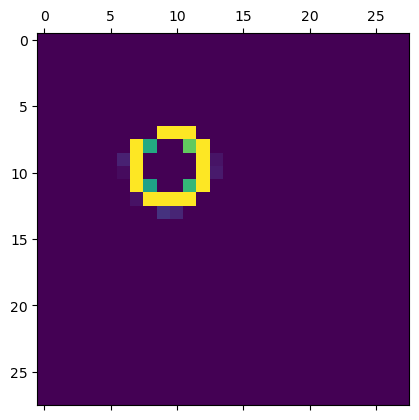

In [15]:
mtrx = np.zeros([28,28])
vector_1= {
    "x" : 1,
    "y" : 0
}
angle = 0.78/2
acc =  0
length = 14
start= {
    "x" : 9,
    "y" : 7
}

mtrx, angle, start, vector_1, _ = sbrain.nnet[0].nrn_tls.nrn_drawer(mtrx, vector_1, angle, length, start,acc)
plt.matshow(mtrx)

In [16]:
45/9

5.0

**nrn_drawer** : position de départ x 9 y 7
**nrn_drawer** : position intermédiaire x 11 y 8
**nrn_drawer** : position intermédiaire x 12 y 8
**nrn_drawer** : angle final: 2.0243190925315058
**nrn_drawer** : position finale x 12 y 8
**nrn_drawer** : dernier vector {'x': 1.003854360540015, 'y': 0.4988473834556587}


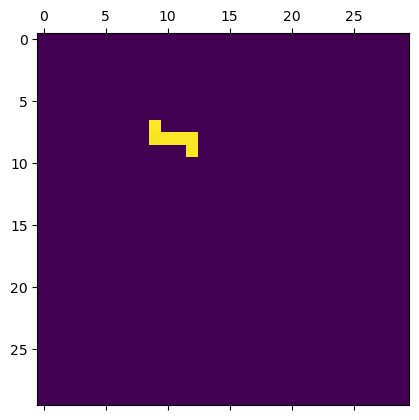

In [17]:
mtrx = np.zeros([30,30])
vector_1= {
    "x" : 0.506529652790199,
    "y" : 1
}
angle = -1.1019386507990419
acc =  1.5631288716652738
length = 3
start= {
    "x" : 9,
    "y" : 7
}

mtrx, angle, start, vector_1, _ = sbrain.nnet[0].nrn_tls.nrn_drawer(mtrx, vector_1, angle, length, start,acc)
plt.matshow(mtrx)


In [18]:
int_counter = 0
for nrn in self.nrn_tls.lst_nrns:
    if nrn.neuron["type"] == "sentive_vision_matrix" and nrn.neuron["layer_id"]==2:
        # compte les neurones vision matrix
        int_counter += 1
print("Nombre de neurones vision matrix", int_counter)

Nombre de neurones vision matrix 36


**nrn_drawer** : position de départ x 12 y 8
**nrn_drawer** : position intermédiaire x 13 y 10
**nrn_drawer** : position intermédiaire x 12 y 10
**nrn_drawer** : position intermédiaire x 11 y 9
**nrn_drawer** : angle final: 1.2972384628321982
**nrn_drawer** : position finale x 11 y 9
**nrn_drawer** : dernier vector {'x': -0.3907409231662274, 'y': -1.0475311599008426}


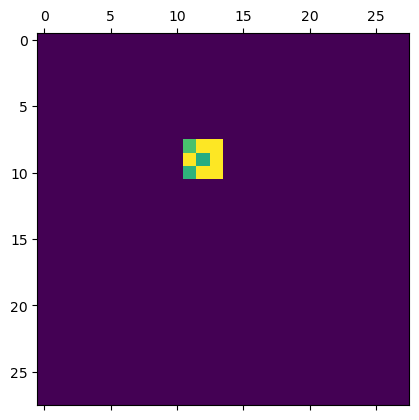

In [19]:
mtrx = np.zeros([28,28])
vector_1= {
    "x" : 1.0,
    "y" : 0.5
}
angle = 1.2972384628321982
acc =  0
length = 4
start= {
    "x" : 12,
    "y" : 8
}

mtrx, angle, start, vector_1, _ = sbrain.nnet[0].nrn_tls.nrn_drawer(mtrx, vector_1, angle, length, start,acc)
plt.matshow(mtrx)

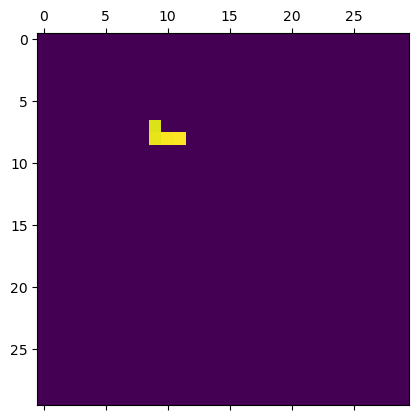

In [20]:
mtrx2 = np.zeros([30,30])
mtrx2 = sbrain.nnet[0].nrn_tls.get_neuron_receptive_field(1, mtrx2)
mtrx2 = sbrain.nnet[0].nrn_tls.get_neuron_receptive_field(2, mtrx2)
mtrx2 = sbrain.nnet[0].nrn_tls.get_neuron_receptive_field(3, mtrx2)
mtrx2 = sbrain.nnet[0].nrn_tls.get_neuron_receptive_field(4, mtrx2)
mtrx2 = mtrx2/5
plt.matshow(mtrx2)

In [21]:
#dimension de la liste des neurones
len(sbrain.nnet[0].nrn_tls.lst_nrns)

105

In [22]:
sbrain.nnet[0].nrn_tls.get_neuron_from_id(2)
# mtrx = nrn3["meta"]["pixels_matrix"]
# plt.matshow(mtrx)


{'_id': 2,
 'schema_version': 2,
 'type': 'sentive_vision_matrix',
 'layer_id': 1,
 'weight': 0.9633017778396606,
 'DbConnectivity': {'pre_synaptique': [],
  'post_synaptique': [],
  'lateral_connexion': [],
  'weights': {}},
 'meta': {'center': {'x': 9, 'y': 8}, 'matrix_width': 1}}

**nrn_drawer** : position de départ x 9 y 7
**nrn_drawer** : position intermédiaire x 11 y 9
**nrn_drawer** : position intermédiaire x 12 y 10
**nrn_drawer** : position intermédiaire x 13 y 11
**nrn_drawer** : position intermédiaire x 14 y 12
**nrn_drawer** : position intermédiaire x 15 y 13
**nrn_drawer** : position intermédiaire x 16 y 14
**nrn_drawer** : position intermédiaire x 17 y 15
**nrn_drawer** : angle final: 0
**nrn_drawer** : position finale x 17 y 15
**nrn_drawer** : dernier vector {'x': 1.0, 'y': 1.0}
save_pos [(10, 8), (12, 10), (11, 9), (15, 13), (17, 15), (14, 12), (16, 14), (9, 7), (13, 11)]


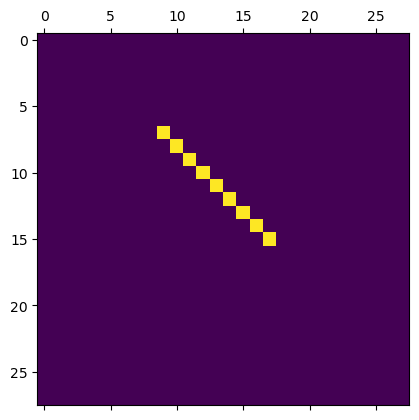

In [23]:
mtrx = np.zeros([28,28])
vector_1= {
    "x" : 1,
    "y" : 1
}
angle = 0
length = 8
start= {
    "x" : 9,
    "y" : 7
}
acc = 0

mtrx, angle, start, vector_1, save_pos = sbrain.nnet[0].nrn_tls.nrn_drawer(mtrx, vector_1, angle, length, start,acc)
plt.matshow(mtrx)
print("save_pos", save_pos)

In [24]:
2*0.461190220866232

0.922380441732464

**nrn_drawer** : position de départ x 11 y 8
**nrn_drawer** : position intermédiaire x 13 y 9
**nrn_drawer** : angle final: 0.7243549945467616
**nrn_drawer** : position finale x 13 y 9
**nrn_drawer** : dernier vector {'x': 0.9021342216356463, 'y': 0.43145549730400484}
save_pos [(13, 9), (11, 8), (12, 8)]


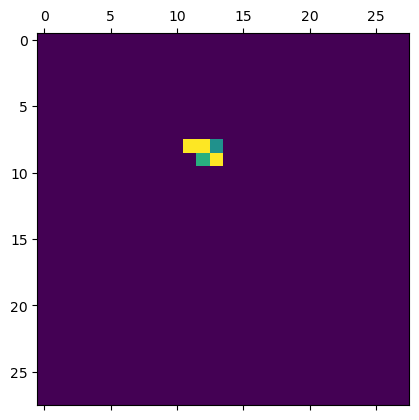

In [25]:
mtrx = np.zeros([28,28])
vector_1= {
    "x" : 0.9486832980505135,
    "y" : 0.3162277660168378
}
angle = 0.1243549945467616
length = 2
start= {
    "x" : 11,
    "y" : 8
}
acc = 0.6

mtrx, angle, start, vector_1, save_pos = sbrain.nnet[0].nrn_tls.nrn_drawer(mtrx, vector_1, angle, length, start,acc)
plt.matshow(mtrx)
print("save_pos", save_pos)

In [26]:
np.max(sbrain.nnet[0].episode[:,:,0])

1.0

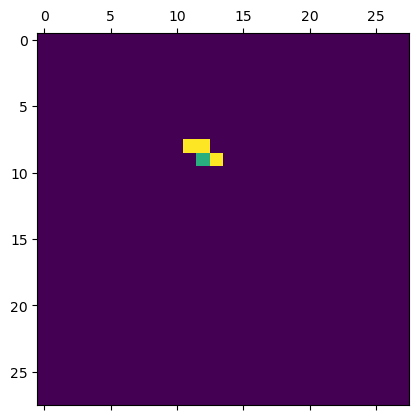

In [27]:
plt.matshow((sbrain.nnet[0].episode[:,:,0]>0) * mtrx)


In [28]:
sbrain.nnet[0].nrn_tls.get_neuron_from_id(39)

{'_id': 39,
 'schema_version': 2,
 'type': 'sentive_vision_matrix',
 'layer_id': 1,
 'weight': 0.7545397877693176,
 'DbConnectivity': {'pre_synaptique': [],
  'post_synaptique': [],
  'lateral_connexion': [],
  'weights': {}},
 'meta': {'center': {'x': 12, 'y': 18}, 'matrix_width': 1}}

In [29]:
sbrain.nnet[0].nrn_tls.lst_nrns[0].neuron

{'_id': 1,
 'schema_version': 2,
 'type': 'sentive_vision_matrix',
 'layer_id': 1,
 'weight': 0.9459211826324463,
 'DbConnectivity': {'pre_synaptique': [],
  'post_synaptique': [],
  'lateral_connexion': [],
  'weights': {}},
 'meta': {'center': {'x': 9, 'y': 7}, 'matrix_width': 1}}

In [30]:
sbrain.nnet[0].nb_nrn_pxls

56

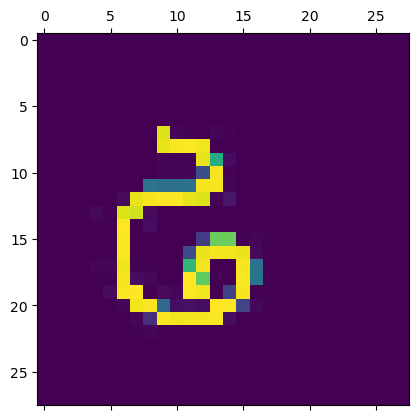

In [31]:
sbrain.nnet[0].show_receptive_field_id(40)

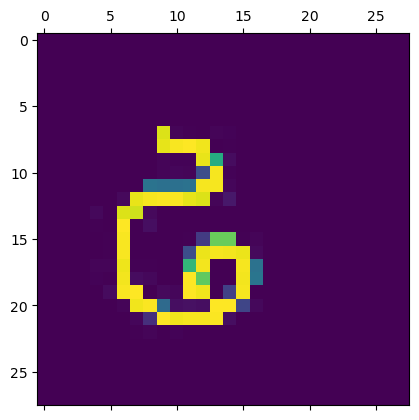

In [32]:
sbrain.nnet[0].show_receptive_field_id(52)

In [33]:
sbrain.nnet[0].nrn_tls.get_neuron_from_id(119)

''

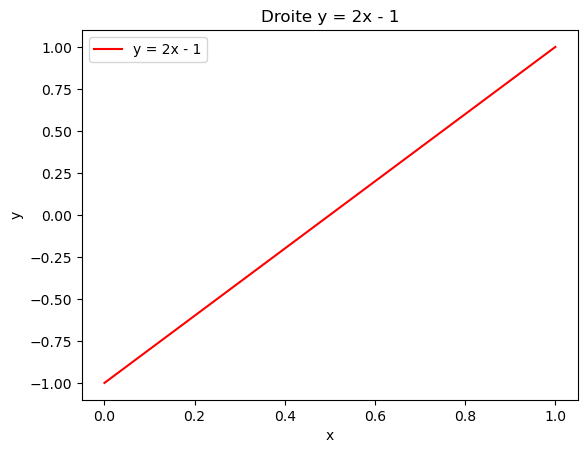

In [34]:
    # Définition des bornes pour x
    x_min = 0
    x_max = 1

    # Génération d'un tableau de valeurs pour x
    x = np.linspace(x_min, x_max)

    # Calcul des valeurs correspondantes pour y
    y = 2 * x - 1

    # Tracé de la droite
    plt.plot(x, y, 'r-', label='y = 2x - 1')

    # Configuration du graphique
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Droite y = 2x - 1')
    plt.legend()

    # Affichage du graphique
    plt.show()

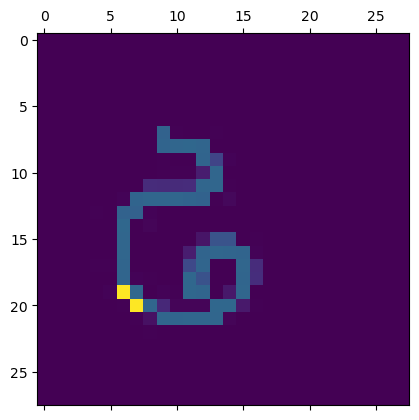

In [35]:
sbrain.nnet[0].show_receptive_field_id(83)

In [36]:
nrn_1 = sbrain.nnet[0].nrn_tls.get_neuron_from_id(75)
vector_1 = nrn_1["meta"]["glbl_prm"]["u_axis"]
nrn_2 = sbrain.nnet[0].nrn_tls.get_neuron_from_id(70)
vector_2 = nrn_2["meta"]["glbl_prm"]["u_axis"]
sbrain.nnet[0].nrn_tls.calc_angle(vector_1, vector_2)

KeyError: 'glbl_prm'

In [ ]:
np_c_1 = np.array([-0.52573111, 0.85065081])
np_c_2 = np.array([-0.52573111, 0.85065081])

In [ ]:
np.arccos(np.sum(np.multiply(np_c_1,np_c_2))/(np.sqrt(np.sum(np.power(np_c_1,2)))*np.sqrt(np.sum(np.power(np_c_2,2)))))

In [ ]:
X = []
Y = []
u_x = []
u_y = []
nb = 0
for nrn in sbrain.nnet[0].nrn_tls.lst_nrns:
    if nrn.neuron["layer_id"] == 2:
        nrn2 = nrn.neuron
        nb += 1
        X.append(nrn2["meta"]["glbl_prm"]["cg"]["x"])
        Y.append(nrn2["meta"]["glbl_prm"]["cg"]["y"])
        u_x.append(nrn2["meta"]["glbl_prm"]["u_axis"]["x"])
        u_y.append(nrn2["meta"]["glbl_prm"]["u_axis"]["y"])
q = plt.quiver(X,Y,u_x,u_y)
for nrn in sbrain.nnet[0].nrn_tls.lst_nrns:
    if nrn.neuron["layer_id"] == 2:
        nrn2 = nrn.neuron
        x = nrn2["meta"]["glbl_prm"]["cg"]["x"]
        y = nrn2["meta"]["glbl_prm"]["cg"]["y"]
        plt.text(x,y, str(nrn2["_id"]))
        for key in nrn2["DbConnectivity"]['angles']:
            y += 0.5
            angle = nrn2["DbConnectivity"]['angles'][key]
            angle = np.abs(angle)
            if angle > (np.pi)/2:
                angle = np.pi - angle
            if angle ==0:
                color = "green"
            elif angle < 0.1:
                color = "yellow"
            elif angle < 0.4:
                color = "orange"
            elif angle < 0.8:
                color = "red"
            else :
                color = "purple"
            plt.text(x,y, str(key),color=color)
            
print(nb)

In [ ]:
angles = []
for nrn in sbrain.nnet[0].nrn_tls.lst_nrns:
    if nrn.neuron["layer_id"] == 2:
        nrn2 = nrn.neuron
        for angle in nrn2["DbConnectivity"]['angles'].values():
            angle = np.abs(angle)
            if angle > (np.pi)/2:
                angle = np.pi - angle
            angles.append(angle)
            
plt.hist(angles)

In [ ]:
def generate_comment(text):
    """
    Generates a formatted comment string.
    
    Parameters
    ----------
    text : str
        The text to be used in the comment.
    
    Returns
    -------
    str
        The formatted comment string.
    """
    comment = "".join(["* " + line for line in text.splitlines()])
    return "/**\n" + comment + "\n*/"


In [ ]:
generate_comment("This is a test")


In [ ]:
np.diff([0.46364760900080615, 0.0, 0.5563215839986531, 0.4331511312763392, 1.04497122052071, -0.4189906125041946, -0.36640755089325333, 0.0, 0.32175055439664196, 0.46364760900080565, 0.4189906125041958, 0.36640755089325294, 0.0, 0.0, 0.3217505543966417, 0.46364760900080615, 0.16964630722702223, 0.12435499454676169, 0.49139686162366436, 0.0, 0.32175055439664196, -1.10714871779409, 1.4781223517970488, 0.3866752767716308])


In [ ]:
plt.plot([-0.46364761,  0.55632158, -0.12317045,  0.61182009, -1.46396183,
        0.05258306,  0.36640755,  0.32175055,  0.14189705, -0.044657  ,
       -0.05258306, -0.36640755,  0.        ,  0.32175055,  0.14189705,
       -0.2940013 , -0.04529131,  0.36704187, -0.49139686,  0.32175055,
       -1.42889927,  2.58527107, -1.09144708])

In [ ]:
# Affiche un un graphique d'une matrice de données
def plot_matrix(point_data, mat_dim=(28, 28)):
    """
    Plots a matrix of data.
    
    Parameters
    ----------
    matrix : list
        The matrix of data to be plotted.
    mat_dim : tuple
        The dimensions of the matrix.
    """
    # Create an empty matrix of zeros of mat_dim dimensions
    matrix = np.zeros(mat_dim)
    # For each element in the matrix
    for point in point_data:
        # Set the value of the element to the value of the matrix
        matrix[point[1]][point[0]] +=1
    # Plot the matrix   
    plt.imshow(np.array(matrix).reshape(mat_dim), cmap='gray')
    plt.show()
plot_matrix([(11, 8), (9, 7), (9, 8), (10, 8)])

In [ ]:
# nrn3:96
plot_matrix([(11, 8), (12, 8), (10, 8), (12, 9)])

In [ ]:
# nrn3:97
plot_matrix([(11, 8), (13, 10), (12, 8), (12, 9)])

In [ ]:
#nrn3:98
plot_matrix([(12, 11), (13, 10), (13, 11), (12, 9)])


In [ ]:
# nrn3:99
plot_matrix([(13, 10), (11, 12), (12, 12), (12, 11), (13, 11)])

In [ ]:
sbrain.nnet[0].nrn_tls.get_neuron_from_id(99)

In [ ]:
sbrain.nnet[0].nrn_tls.calc_angle({'x': 0.9899494936611662, 'y': -0.14142135623730961},{"x":0, "y":1} )

In [ ]:
sbrain.nnet[0].nrn_tls.calc_angle({"x":0, "y":1}, {'x': 1, 'y': -0.3} )